In [2]:
%load_ext autoreload
%autoreload 2

from ETL import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Small sensors

As an example, let's build modules, readout boards and power boards for small sensors.
A small sensor consists of 16x16 pads, and measures 21.75 x 22mm, with a 0.5mm wide dead area all around the sensor.

2x2 sensors will be placed on one module, with a gap of 0.1mm between them.

This is a baseline, but we can investigate how the efficiency hit efficiency is impacted if the sensor gaps and/or module gaps are changed


In [3]:
sensor_x = 21.75
sensor_y = 22
sensor_gap_x = 0.1
sensor_gap_y = 0.5
module_x = 0.6 + 2*sensor_x + sensor_gap_x
module_y = 56.50

s = Sensor(sensor_x, sensor_y, deadspace=0.5)

m = Module(module_x, module_y,
           n_sensor_x = 2,
           n_sensor_y = 2,
           sensor_distance_y = sensor_y + sensor_gap_y,
           sensor_distance_x=sensor_x+sensor_gap_x
          )

# populate the module with sensors
m.populate(s)

# create some readout and power boards.
# The x dimension will be aligned later on, so we just use a dummy value of 10mm.

rb = ReadoutBoard(10, module_y, color='green')
pb = ReadoutBoard(10,29.5, color='red')


We can look at one module to see if we didn't screw up any dimenstions.

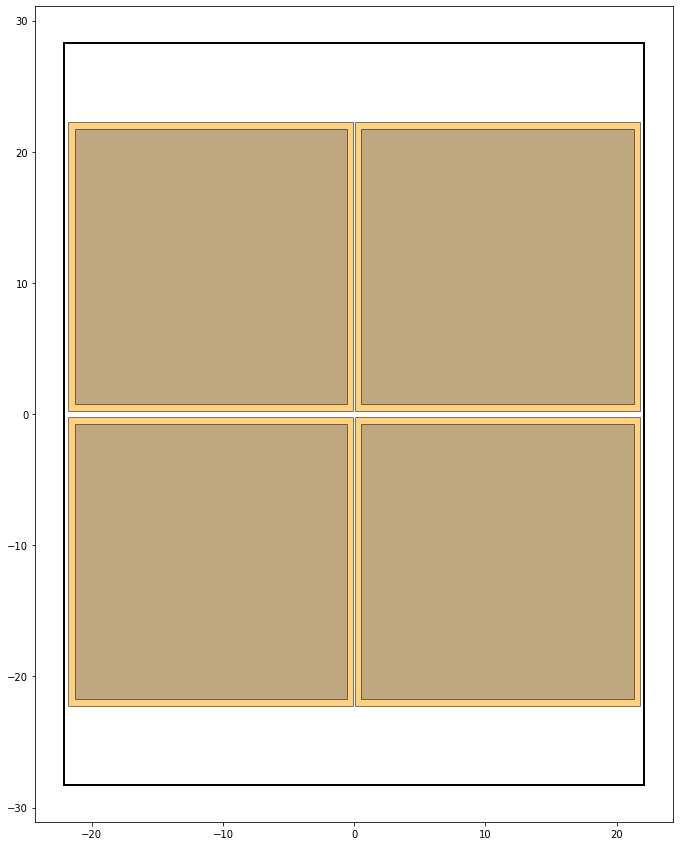

In [4]:
plt.rcParams['figure.figsize'] = [15, 15]

pm = m.getPolygon()
plt.gca().add_patch(pm)

for sen in m.sensors:
    plt.gca().add_patch(sen.getPolygon())
    plt.gca().add_patch(sen.getPolygon(active=True))
    
plt.axis('scaled')
plt.show()

## Populate the disks with sensors and modules

First, we create super modules out of N modules, power and readout boards.
The smallest entity will probably contain 3 modules, so let's use them as starting point.
We assume a gap of 0.5 mm between the modules.
The power board can be either above or below the modules, which is set with the orientation parameter.

Then, we can create a dee with inner/outer radius of 315 and 1185mm.



In [5]:
r_inner = 315
r_outer = 1185

module_gap = 0.5

edge_x = 6  # 6mm is the default

detector = {}

SM = SuperModule(m, pb, rb, n_modules=3, module_gap=module_gap, orientation='above')

detector['disk1_front'] = Dee(r_inner, r_outer)
detector['disk1_front'].populate(SM, edge_x=edge_x, center_RB=True)

SM = SuperModule(m, pb, rb, n_modules=3, module_gap=module_gap, orientation='above')

detector['disk1_back'] = Dee(315, 1185)
detector['disk1_back'].populate(SM, edge_x=edge_x, center_PB=True)

SM = SuperModule(m, pb, rb, n_modules=3, module_gap=module_gap, orientation='below')

detector['disk2_front'] = Dee(315, 1185)
detector['disk2_front'].populate(SM, edge_x=edge_x, center_RB=True)

SM = SuperModule(m, pb, rb, n_modules=3, module_gap=module_gap, orientation='below')

detector['disk2_back'] = Dee(315, 1185)
detector['disk2_back'].populate(SM, edge_x=edge_x, center_PB=True)



## Supermodule

We can then look at one of the previously created super modules.
The last one we created has the power board below the modules, and contains 3 modules.
Let's see if this is actually the case.


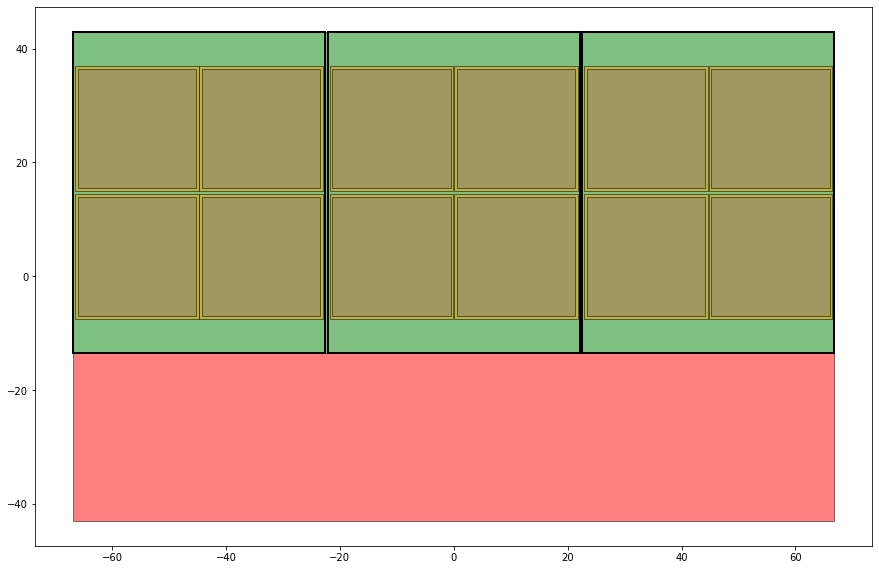

In [6]:
plt.rcParams['figure.figsize'] = [15, 15]

#plt.gca().add_patch(SM.getPolygon())
plt.gca().add_patch(SM.PB.getPolygon())
plt.gca().add_patch(SM.RB.getPolygon())

for mod in SM.modules:
    plt.gca().add_patch(mod.getPolygon())
    for sen in mod.sensors:
        plt.gca().add_patch(sen.getPolygon())
        plt.gca().add_patch(sen.getPolygon(active=True))

plt.axis('scaled')
plt.show()

## Active area of the full detector

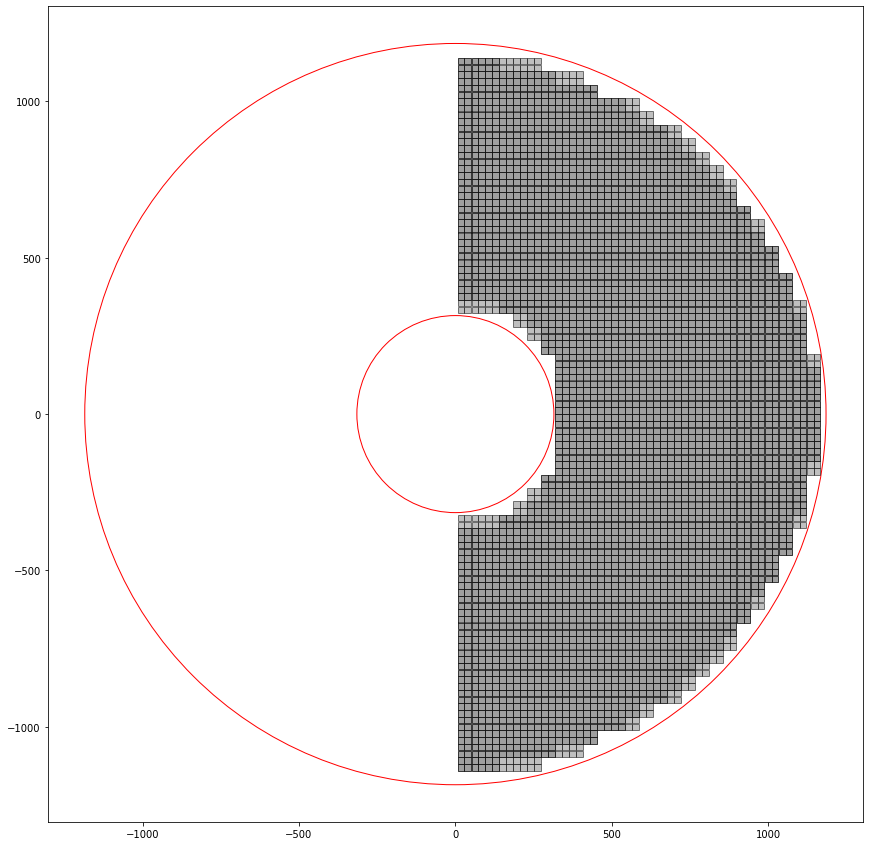

In [7]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

for dee in detector:
    for slot in detector[dee].slots_flat:
        if slot.covered:
            #plt.gca().add_patch(slot.getPolygon())
            #plt.gca().add_patch(slot.RB.getPolygon())
            #plt.gca().add_patch(slot.PB.getPolygon())
            for mod in slot.modules:
                for sen in mod.sensors:
                    plt.gca().add_patch(sen.getPolygon(active=True))


#plt.savefig('test.pdf')
        
plt.axis('scaled')
plt.show()

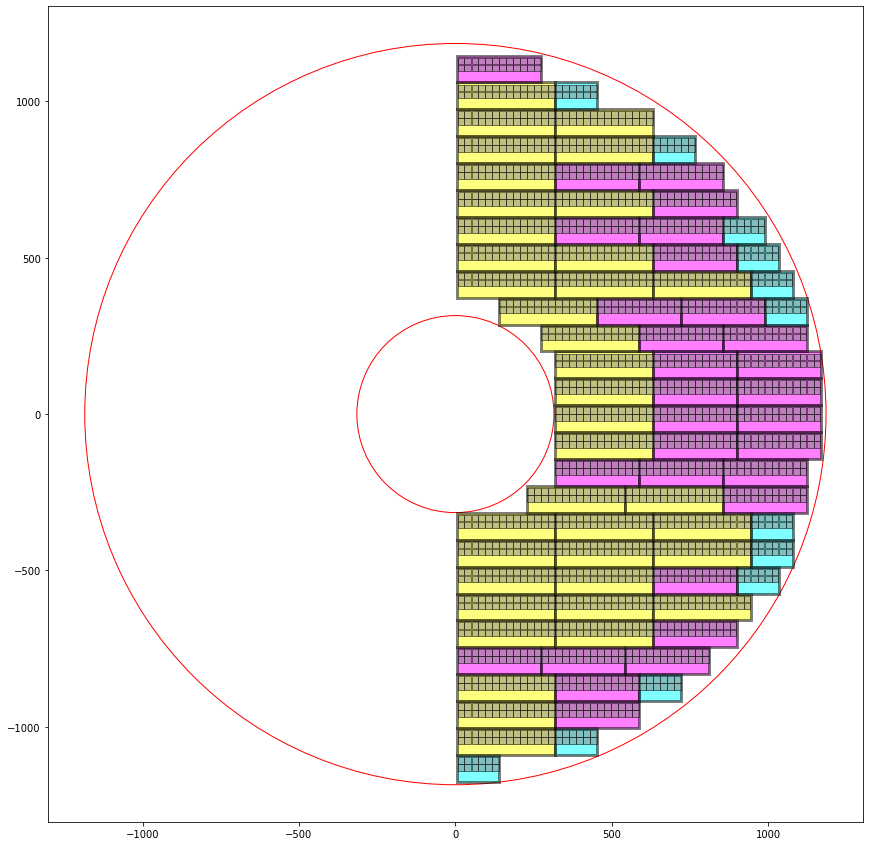

In [8]:

inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

for SM in detector['disk2_front'].supermodules:
    plt.gca().add_patch(SM.getPolygon())

for slot in detector['disk2_front'].slots_flat:
    if slot.covered:
        for mod in slot.modules:
            for sen in mod.sensors:
                plt.gca().add_patch(sen.getPolygon(active=True))

#plt.savefig('test.pdf')
        
plt.axis('scaled')
plt.show()

# Throwing random coordinates

In [9]:
z_ref = 2.99825
z = [
    2.99825,
    3.0055,
    3.02075,
    3.0285,
]

In [10]:
import time
import random

starttime = time.time()

eta_max = 2.950
eta_min = 1.659
eta_range = eta_max-eta_min

nEvents = int(1e5)

eta = np.random.rand(nEvents)*eta_range + eta_min
phi = np.random.rand(nEvents)*np.pi - np.pi/2

vec = three_vector.fromEtaPhi(eta, phi, np.ones(nEvents)*z_ref*1000)

vec_list = []
for x,y in zip(vec.x, vec.y):
    vec_list.append(three_vector(x,y,z_ref*1000))

hits = {
    'baseline':[],
    
       }
   
nHits = {
    'baseline':[],
}

detector_variants = {
    'baseline': detector,
    #'remove_face': detector_remove,
    }

layers = ['disk1_front', 'disk1_back', 'disk2_front', 'disk2_back']


for v in vec_list:    
    for det in detector_variants:
        n = 0
        iLayer = 0
        nModules = 0

        for layer in layers:
            x_shift = 1000*(z[iLayer]-z_ref)*np.tan(v.theta)*np.cos(v.phi)
            y_shift = 1000*(z[iLayer]-z_ref)*np.tan(v.theta)*np.sin(v.phi)
            x,y = ((v.x + x_shift), (v.y + y_shift))
                
            if detector_variants[det][layer].intersect(x, y):
                n += 1
            iLayer += 1
            
            nModules += sum( [ sum([ x for x in row if x==1]) for row in detector_variants[det][layer].module_matrix ])
            
        if n>0: hits[det].append(v)
        nHits[det].append(n)
        
print ("Detector option %s:"%det)
print (" - Number of modules: %s"%(nModules*4))
    
    

endtime = time.time()

print (endtime-starttime)

Detector option baseline:
 - Number of modules: 7704
23.956357955932617


In [11]:
from yahist import Hist1D

from yahist.utils import fit_hist, ignore_division_errors
import scipy

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


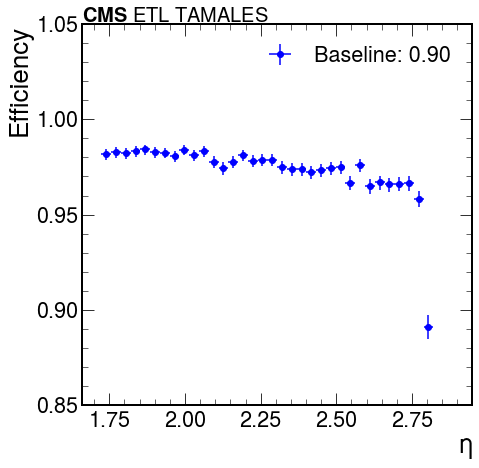

In [12]:
import os
import mplhep as hep

plt.style.use(hep.style.CMS)  # or ATLAS/LHCb

bins = "40,1.659,2.950"

num = Hist1D([v.eta for v in hits['baseline']], bins=bins)
den = Hist1D([v.eta for v in vec_list], bins=bins)

fig, ax = plt.subplots(1,1,figsize=(7,7))

h = num.divide(den, binomial=True)

h.plot(show_errors=True, color="blue", label='Baseline: %.2f'%(len(hits['baseline'])/len(vec_list)))

ax.set_ylabel('Efficiency')
ax.set_xlabel(r'$\eta$')

ax.set_ylim(0.85,1.05)

fig.text(0.0, 0.995, '$\\bf{CMS}$ ETL TAMALES', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

name = 'efficiency_examples'

fig.savefig(os.path.join("{}.pdf".format(name)))
fig.savefig(os.path.join("{}.png".format(name)))

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


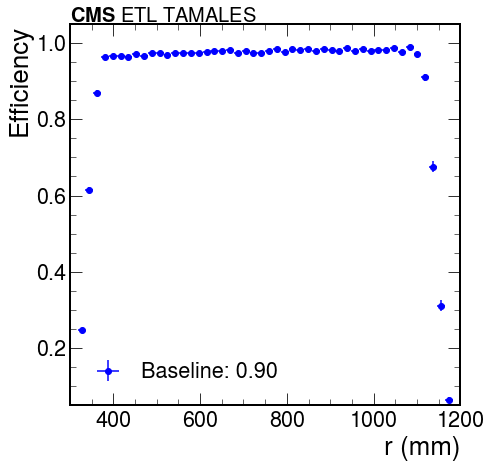

In [13]:
bins = "50,300,1200"

num = Hist1D([v.r for v in hits['baseline']], bins=bins)
den = Hist1D([v.r for v in vec_list], bins=bins)

fig, ax = plt.subplots(1,1,figsize=(7,7))

h = num.divide(den, binomial=True)

h.plot(show_errors=True, color="blue", label='Baseline: %.2f'%(len(hits['baseline'])/len(vec_list)))

ax.set_ylabel('Efficiency')
ax.set_xlabel('r (mm)')

ax.set_ylim(0.05,1.05)

fig.text(0.0, 0.995, '$\\bf{CMS}$ ETL TAMALES', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

name = 'efficiency_vs_r'

fig.savefig(os.path.join("{}.pdf".format(name)))
fig.savefig(os.path.join("{}.png".format(name)))

In [14]:
h

[ 0.01 ± 0.00    0.25 ± 0.01    0.61 ± 0.01    0.87 ± 0.01    0.96 ± 0.00
  0.97 ± 0.00    0.97 ± 0.00    0.96 ± 0.00    0.97 ± 0.00    0.97 ± 0.00
  0.97 ± 0.00    0.98 ± 0.00    0.97 ± 0.00    0.97 ± 0.00    0.97 ± 0.00
  0.97 ± 0.00    0.97 ± 0.00    0.98 ± 0.00    0.98 ± 0.00    0.98 ± 0.00
  0.98 ± 0.00    0.98 ± 0.00    0.98 ± 0.00    0.97 ± 0.00    0.98 ± 0.00
  0.98 ± 0.00    0.98 ± 0.00    0.98 ± 0.00    0.99 ± 0.00    0.98 ± 0.00
  0.98 ± 0.00    0.98 ± 0.00    0.98 ± 0.00    0.98 ± 0.00    0.98 ± 0.00
  0.99 ± 0.00    0.98 ± 0.00    0.99 ± 0.00    0.98 ± 0.00    0.98 ± 0.00
  0.98 ± 0.00    0.99 ± 0.00    0.98 ± 0.00    0.99 ± 0.00    0.97 ± 0.01
  0.91 ± 0.01    0.68 ± 0.01    0.31 ± 0.01    0.06 ± 0.01     nan ±  nan]

In [15]:
test = Hist1D(nHits['baseline'], bins="5,-0.5,4.5")
test

bin,content
"(-0.5,0.5)",10371 ± 101.838
"(0.5,1.5)",20165 ± 142.004
"(1.5,2.5)",66795 ± 258.447
"(2.5,3.5)",2641 ± 51.3907
"(3.5,4.5)",28 ± 5.2915


In [16]:
np.mean(nHits['baseline'])

1.6179

In [17]:
df = pd.DataFrame(nHits)

In [18]:
len(df['baseline'][df['baseline']>1])/len(nHits['baseline'])

0.69464

## Potential descoping

WIP

In [26]:
d = detector_variants['baseline']['disk2_back']
filled_slots = sum( [ sum([ x for x in row if x==1]) for row in d.module_matrix ])
filled_slots*2 # rough estimate of total number of modules

464

In [27]:
SM = SuperModule(m, pb, rb, n_modules=3, module_gap=module_gap, orientation='above')

descoped = Dee(315, 1080)
descoped.populate(SM, edge_x=6, center_PB=True)

filled_slots = sum( [ sum([ x for x in row if x==1]) for row in descoped.module_matrix ])
filled_slots

385

In [28]:
0.8*481

384.8